In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import os
import random

#warnings removal
import warnings
warnings.filterwarnings('ignore')

import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image

2024-08-07 12:22:44.565069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 12:22:44.565128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 12:22:44.566522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#reading the path to the dataset folder
dataset_path = '/kaggle/input/leapgestrecog/leapGestRecog'

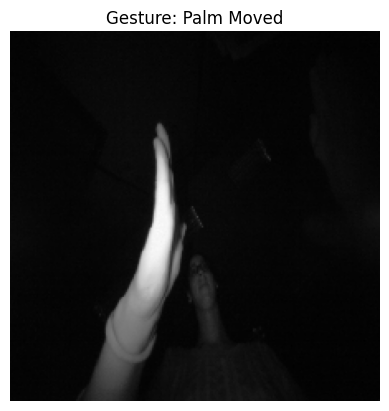

In [3]:
image_path = '/kaggle/input/leapgestrecog/leapGestRecog/09/08_palm_moved/frame_09_08_0007.png'

image = load_img(image_path, target_size=(224, 224))

plt.imshow(image)
plt.title('Gesture: Palm Moved')
plt.axis('off')
plt.show()

In [4]:
#setting up logging configuration
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

In [5]:
#loading the images, debugging without cluttering the console with too much information
def load_images_from_subfolders(folder, size=(64, 64), valid_extensions=['.png']):
    images = []
    labels = []
    subdirectory_names = []  #to store the subdirectory names
    label_dict = {}
    supported_extensions = [ext.lower() for ext in valid_extensions]

    def recursive_load_images(dir_path, label):
        for item in os.listdir(dir_path):
            item_path = os.path.join(dir_path, item)
            if os.path.isdir(item_path):
                recursive_load_images(item_path, label)  #recursively checking subdirectories
            elif os.path.isfile(item_path):
                if any(item_path.lower().endswith(ext) for ext in supported_extensions):
                    try:
                        img = cv2.imread(item_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, size)
                            images.append(img)
                            labels.append(label_dict[label])
                            subdirectory_names.append(label)  #store the subdirectory name
                    except Exception as e:
                        print(f"Error loading image {item_path}: {e}")

    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            if label not in label_dict:
                label_dict[label] = len(label_dict)
            recursive_load_images(label_path, label)
    
    return np.array(images), np.array(labels), np.array(subdirectory_names), label_dict

In [6]:
images, labels, subdirectory_names, label_dict = load_images_from_subfolders(dataset_path)

Images shape: (20000, 64, 64)
Labels shape: (20000,)
Number of classes: 10


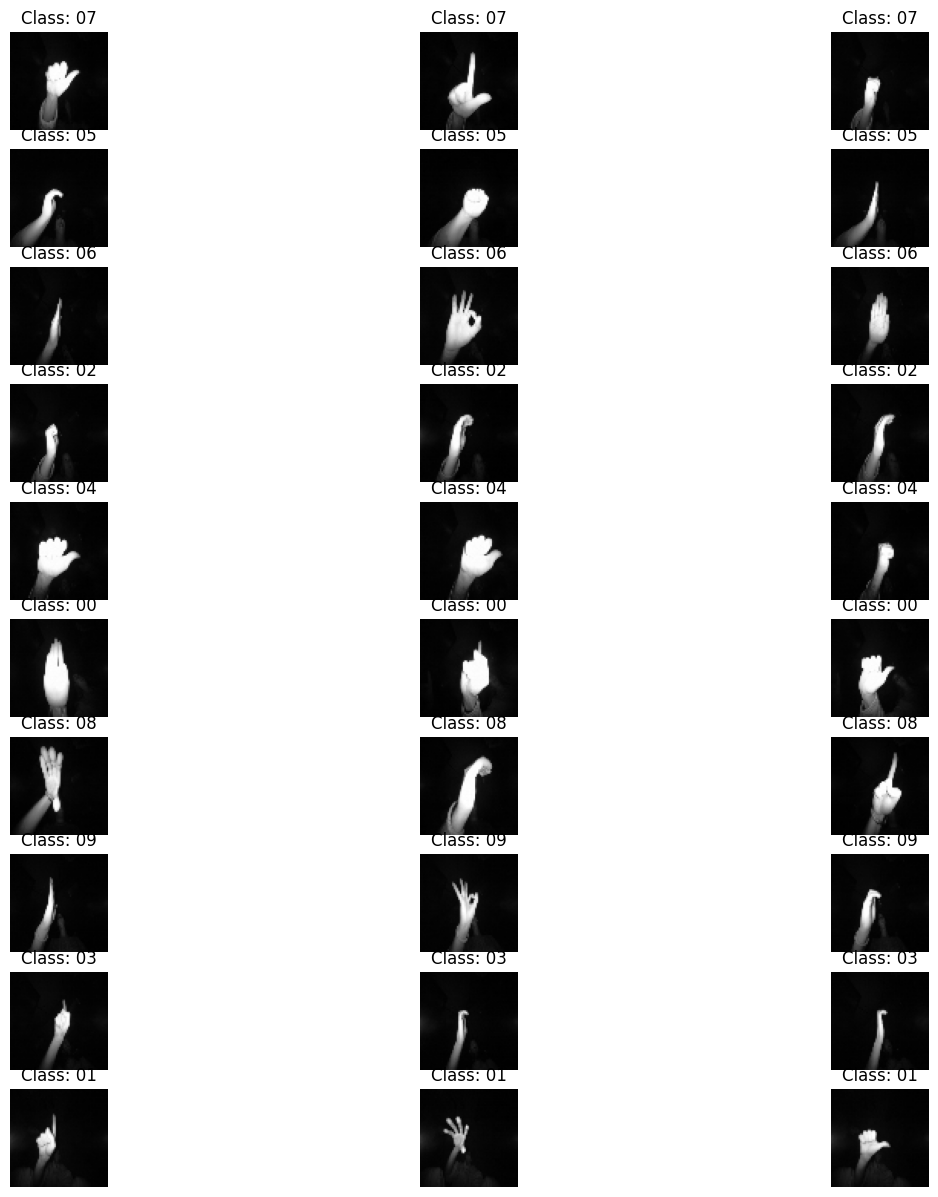

In [7]:
#test the function to ensure images are loaded and print images from the subdirectories
def test_loaded_images(images, labels,label_dict, subdirectory_names, images_per_class=3):
    #printing the shape of the images and labels arrays
    print(f'Images shape: {images.shape}')
    print(f'Labels shape: {labels.shape}')
    print(f'Number of classes: {len(label_dict)}')

    #display a few images with their labels from different classes
    plt.figure(figsize=(15, 15))
    unique_labels = np.unique(labels) #unique_labels ensures that the variable is available for use within the function
    total_images_displayed = 0
    
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        np.random.shuffle(label_indices)  #shuffle indices to get different images
        for i, idx in enumerate(label_indices[:images_per_class]):
            plt.subplot(len(unique_labels), images_per_class, total_images_displayed + 1)
            plt.imshow(images[idx], cmap='gray')
            plt.title(f'Class: {subdirectory_names[idx]}')
            plt.axis('off')
            total_images_displayed += 1
    plt.show()

#test
test_loaded_images(images, labels, label_dict, subdirectory_names)

In [8]:
#printing label dictionary and number of samples
print("Label dictionary:", label_dict)
print("Number of training samples:", len(images))

Label dictionary: {'07': 0, '05': 1, '06': 2, '02': 3, '04': 4, '00': 5, '08': 6, '09': 7, '03': 8, '01': 9}
Number of training samples: 20000


In [9]:
#preparing the data
x = images.reshape((images.shape[0], 64, 64, 1))  #images are 64x64 grayscale
y = to_categorical(labels, num_classes=len(label_dict))

In [10]:
#splitting the data into training and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"Training samples: {len(x_train)}, Validation samples: {len(x_val)}")

Training samples: 14000, Validation samples: 6000


In [11]:
#building the model with dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_dict), activation='softmax')
])

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#to suppress TensorFlow warnings
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [13]:
#training
history = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/15
 27/438 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0775 - loss: 17.3532

I0000 00:00:1723033448.306145    1634 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723033448.326038    1634 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1820 - loss: 3.9561

W0000 00:00:1723033455.594071    1634 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723033456.383366    1633 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.1822 - loss: 3.9520 - val_accuracy: 0.7720 - val_loss: 0.7388
Epoch 2/15
 31/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4966 - loss: 1.2685

W0000 00:00:1723033457.183199    1634 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5532 - loss: 1.1141 - val_accuracy: 0.9483 - val_loss: 0.2649
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7189 - loss: 0.6947 - val_accuracy: 0.9800 - val_loss: 0.0988
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7939 - loss: 0.4975 - val_accuracy: 0.9868 - val_loss: 0.0575
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8604 - loss: 0.3442 - val_accuracy: 0.9883 - val_loss: 0.0269
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8965 - loss: 0.2547 - val_accuracy: 0.9902 - val_loss: 0.0198
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9207 - loss: 0.1935 - val_accuracy: 0.9905 - val_loss: 0.0163
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9406 - loss: 0.1458 - val_accuracy: 0.9928 - val_loss: 0.0126
Epoch 9/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9573 - loss: 0.1076 - val_accuracy: 0.9908 - val_

In [14]:
#prediction on training data
y_train_pred = model.predict(x_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)

117/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1723033487.383966    1633 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1723033488.265174    1633 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [21]:
#prediction on training data
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [15]:
#classification report for training data
print("Training Classification Report:")
print(classification_report(y_train_true_classes, y_train_pred_classes, target_names=list(label_dict.keys())))

Training Classification Report:
              precision    recall  f1-score   support

          07       1.00      1.00      1.00      1435
          05       0.91      1.00      0.95      1376
          06       1.00      1.00      1.00      1410
          02       1.00      0.90      0.95      1390
          04       1.00      1.00      1.00      1372
          00       1.00      1.00      1.00      1416
          08       1.00      1.00      1.00      1382
          09       1.00      1.00      1.00      1382
          03       1.00      1.00      1.00      1420
          01       1.00      1.00      1.00      1417

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



In [16]:
#classification report for validation set
#val prediction
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

val_report = classification_report(y_val_true, y_val_pred_classes, target_names=label_dict.keys())
print("Validation Classification Report:\n", val_report)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Classification Report:
               precision    recall  f1-score   support

          07       1.00      1.00      1.00       565
          05       0.92      1.00      0.96       624
          06       1.00      1.00      1.00       590
          02       1.00      0.91      0.95       610
          04       1.00      1.00      1.00       628
          00       1.00      1.00      1.00       584
          08       1.00      1.00      1.00       618
          09       1.00      1.00      1.00       618
          03       1.00      1.00      1.00       580
          01       1.00      1.00      1.00       583

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



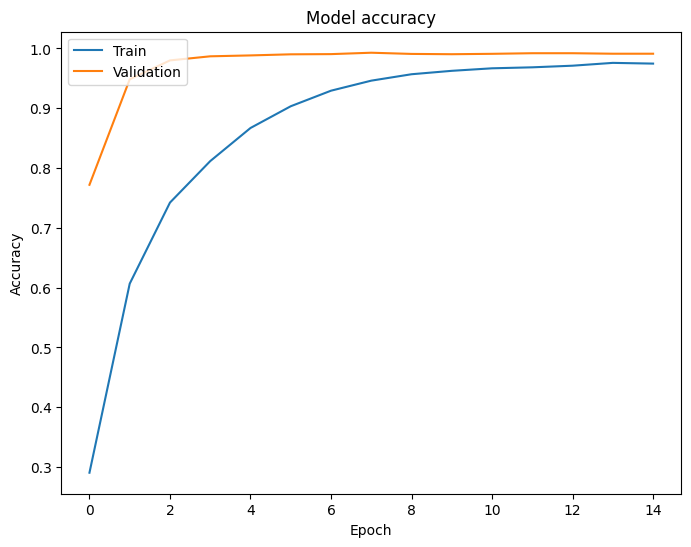

In [17]:
#plotting training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

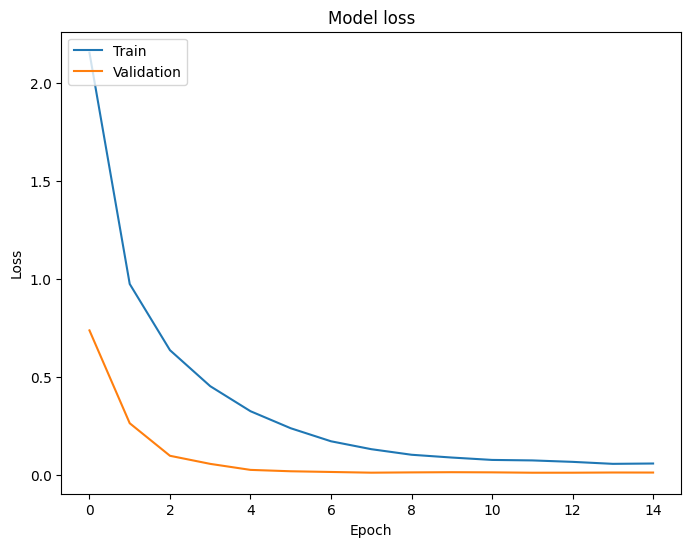

In [18]:
#plotting training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

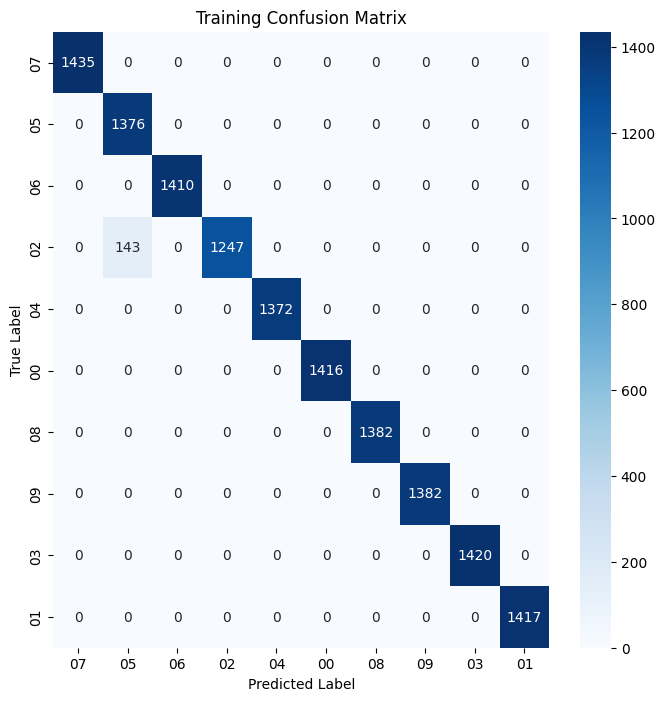

In [23]:
#confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train_true_classes, y_train_pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_dict.keys()), yticklabels=list(label_dict.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Confusion Matrix')
plt.show()

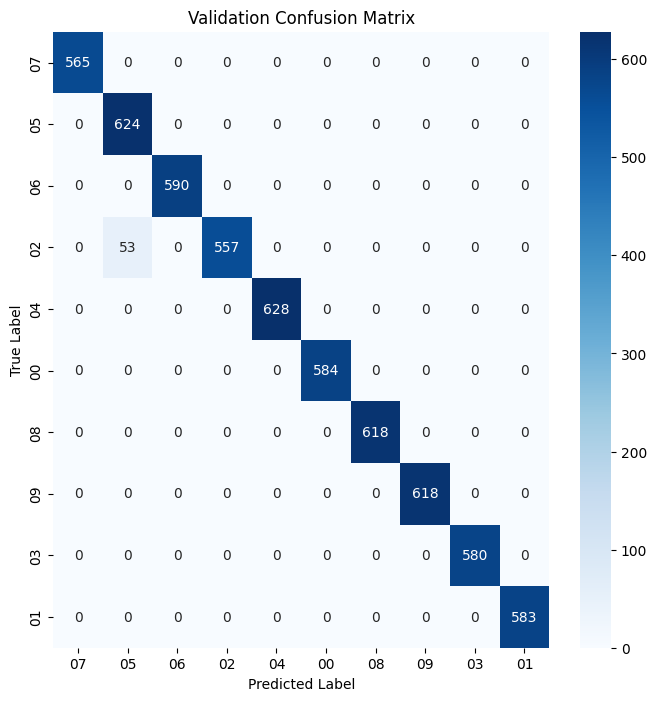

In [22]:
#confusion matrix for validation data
val_conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_dict.keys()), yticklabels=list(label_dict.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Confusion Matrix')
plt.show()

In [29]:
#a few samples from the validation set
num_samples = 6  #num of samples to test
sample_indices = np.random.choice(len(x_val), num_samples, replace=False)
sample_images = x_val[sample_indices]
sample_labels = np.argmax(y_val[sample_indices], axis=1)

In [30]:
#predicting the class of the selected samples
sample_predictions = model.predict(sample_images)
sample_pred_classes = np.argmax(sample_predictions, axis=1)
sample_pred_labels = [k for k, v in sorted(label_dict.items(), key=lambda item: item[1])]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


W0000 00:00:1723033933.517274    1633 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Sample 1:
True label: 08
Predicted label: 08


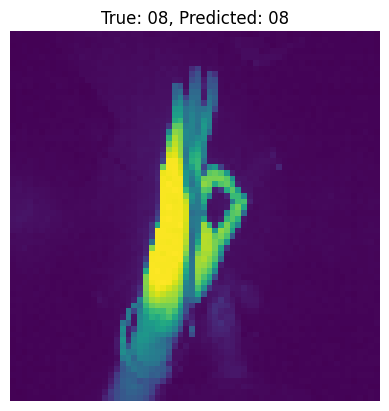

Sample 2:
True label: 05
Predicted label: 05


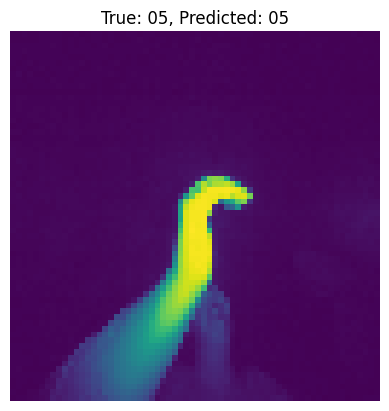

Sample 3:
True label: 04
Predicted label: 04


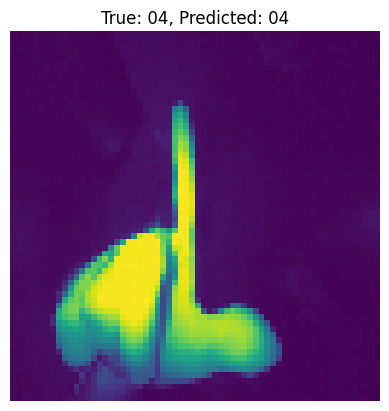

Sample 4:
True label: 00
Predicted label: 00


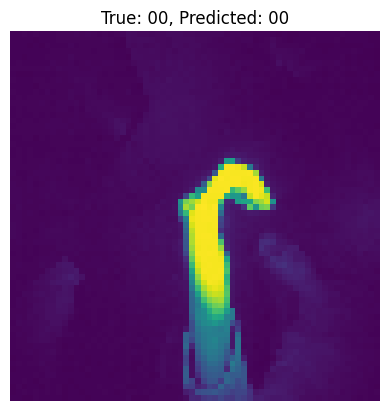

Sample 5:
True label: 09
Predicted label: 09


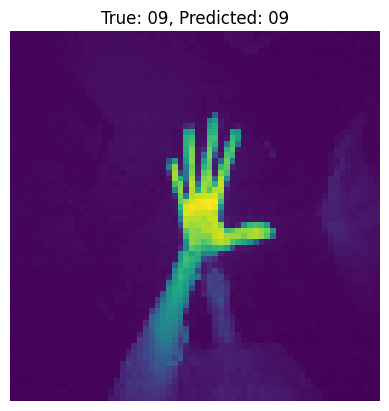

Sample 6:
True label: 05
Predicted label: 05


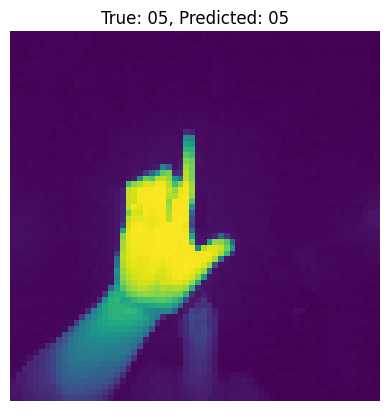

In [31]:
#printing predictions and true labels
for i in range(num_samples):
    print(f"Sample {i+1}:")
    print(f"True label: {sample_pred_labels[sample_labels[i]]}")
    print(f"Predicted label: {sample_pred_labels[sample_pred_classes[i]]}")
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_pred_labels[sample_labels[i]]}, Predicted: {sample_pred_labels[sample_pred_classes[i]]}")
    plt.axis('off')
    plt.show()